In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
emissions = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3159114.csv", skiprows=3)

# processing the CO2 emissions dataset to only show Indonesia
indo_emissions = emissions.loc[emissions["Country Name"] == "Indonesia"]
indo_emissions.drop("Unnamed: 65", axis=1, inplace=True)
# dropping the NaN values as it doesn't affect the analysis
indo_emissions.drop(["2019", "2020"], axis=1, inplace=True)

# slicing the dataframe to get usable features
indo_emissions = indo_emissions.iloc[:, 4:]
indo_emissions = indo_emissions.transpose()
indo_emissions.rename(columns={106:"CO2 emissions (metric tons per capita)"}, inplace=True)
indo_emissions.index = pd.to_datetime(indo_emissions.index)

# renaming the index
indo_emissions.index.name = "dt" 
indo_emissions

,CO2 emissions (metric tons per capita)
dt,
1960-01-01,0.243920
1961-01-01,0.288848
1962-01-01,0.248553
1963-01-01,0.239783
1964-01-01,0.229458
1965-01-01,0.246241
1966-01-01,0.227084
1967-01-01,0.232007
1968-01-01,0.253602


<AxesSubplot:xlabel='dt'>

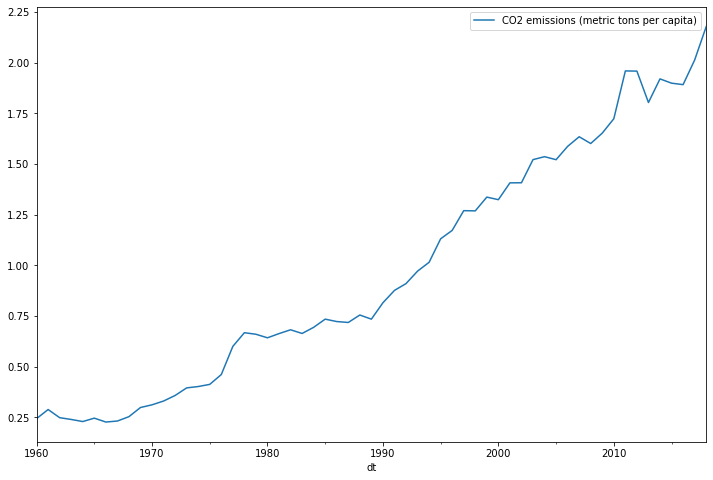

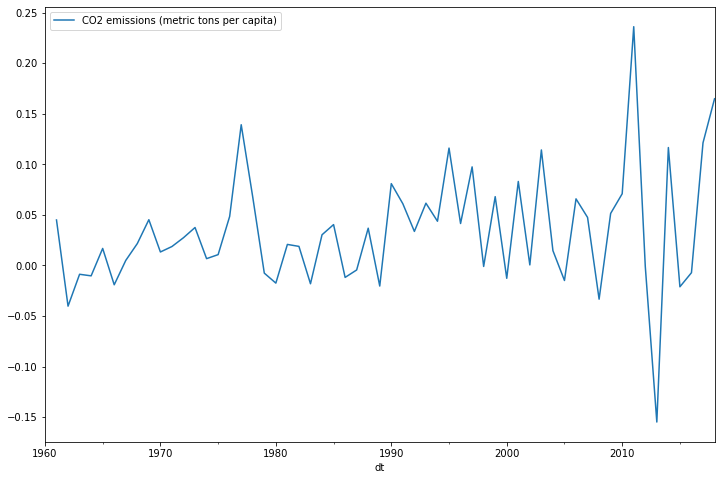

In [3]:
# plotting the original dataset and the first differential
indo_emissions.plot(figsize=(12, 8))
indo_emissions.diff().plot(figsize=(12, 8))

In [4]:
# forecasting using the ARIMA model
# using the ADF test to find the p-value
# since the p-value is above the threshhold (0.5%), the time series is not stationary
results = adfuller(indo_emissions["CO2 emissions (metric tons per capita)"])
print("ADF Statistic: %f" %results[0])
print("p-value: %f" %results[1])

ADF Statistic: 1.457208
p-value: 0.997359


In [5]:
# splitting the datasets into train and test
# using a 75:15:10 split
n = len(indo_emissions)
train, validation, test = indo_emissions[:int(n*0.75)], indo_emissions[int(n*0.75):int(n*0.9)], indo_emissions[int(n*0.9):]

In [6]:
def optimize_SARIMAX(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
# finding out the most optimal ARIMA model to use
ps = range(0, 8, 1)
d = range(0, 8, 1)
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []
for parameter in parameters_list:
    parameter = list(parameter)
    parameter.insert(1, 1)
    parameter = tuple(parameter)
    order_list.append(parameter)

results_df = optimize_SARIMAX(order_list, indo_emissions)

results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(1, 1, 1)",-156.233926
1,"(1, 1, 3)",-154.382036
2,"(3, 1, 1)",-154.346835
3,"(1, 1, 2)",-154.252520
4,"(2, 1, 1)",-154.245045
...,...,...
59,"(6, 1, 6)",-142.829515
60,"(5, 1, 6)",-142.725177
61,"(5, 1, 7)",-142.478655
62,"(6, 1, 7)",-141.442117


In [13]:
# using the most optimal ARIMA model (110)
model = SARIMAX(indo_emissions, order=(1,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:     CO2 emissions (metric tons per capita)   No. Observations:                   59
Model:                   SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  56.688
Date:                                    Thu, 13 Jan 2022   AIC                           -105.377
Time:                                            08:44:30   BIC                            -98.062
Sample:                                        01-01-1960   HQIC                          -102.636
                                             - 01-01-2018                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0488      0.190      0.256      0

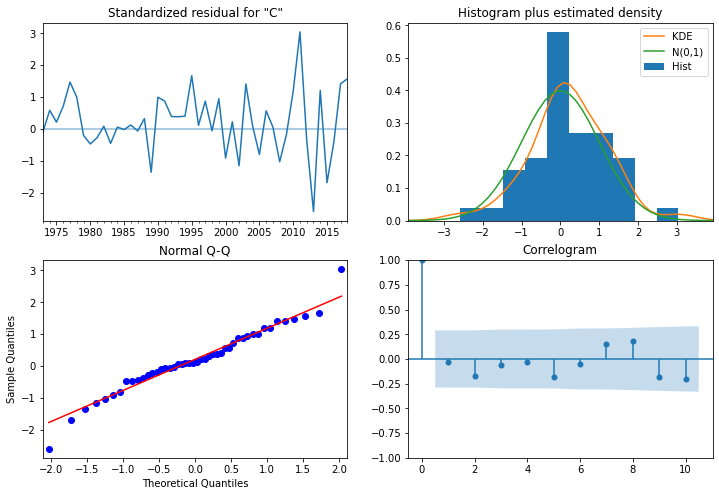

In [14]:
# residual plot
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

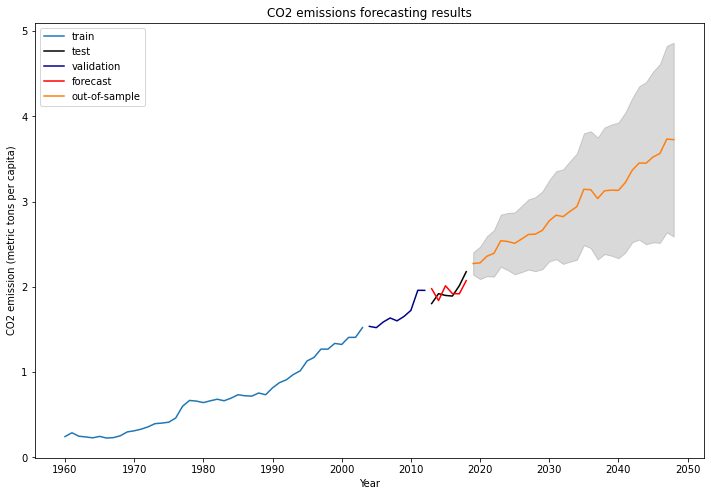

In [16]:
# plotting the prediction
results = model_fit.predict(start=int(n*0.9))
forecast = model_fit.get_forecast(steps=30)
out_of_sample = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# confidence interval plot
lower_bound = pd.Series(conf_int.iloc[:,0])
upper_bound = pd.Series(conf_int.iloc[:,1]) 

plt.plot(train, label="train")
plt.plot(test, label="test", color="black")
plt.plot(validation, label="validation", color="darkblue")
plt.plot(results, label="forecast", color='red')
plt.plot(out_of_sample, label="out-of-sample")
plt.fill_between(lower_bound.index, lower_bound, upper_bound, color="k", alpha=.15)
plt.title("CO2 emissions forecasting results")
plt.xlabel("Year")
plt.ylabel("CO2 emission (metric tons per capita)")
plt.legend(loc='upper left')

In [17]:
# regression analysis
def pred_accuracy(prediction, actual):
    mae = np.mean(np.abs(prediction-actual))
    mape = np.mean(np.abs(prediction-actual) / np.abs(actual))
    mpe = np.mean((prediction-actual)/actual)
    rmse = np.mean((prediction - actual)**2)**0.5
    return {"MAPE" : mape, "MPE" : mpe, "MAE" : mae, "RMSE" : rmse}

pred_accuracy(results.values, test.values)

{'MAPE': 0.057017914980162177,
 'MPE': 0.006551340132822507,
 'MAE': 0.11246268633689582,
 'RMSE': 0.14017248358812362}

[2.2741120137006177, 2.281801406575414, 2.3604519879014974, 2.393084325052297, 2.541653523307222, 2.5322571431006056, 2.510660870507628, 2.5611637285382494, 2.615032128931751, 2.6185826159511367, 2.6629796116067452, 2.775252035865246, 2.8415197466714757, 2.8238236254806757, 2.885615265082254, 2.9418933894882335, 3.1445754714782983, 3.1403722152926328, 3.0363385946302253, 3.1276909610736974, 3.1351658594832403, 3.1320561575035404, 3.2239744956590615, 3.36872935169505, 3.453170299895539, 3.451175125108828, 3.5233940241215067, 3.5650472235637167, 3.7342604742706853, 3.7268452696599437]


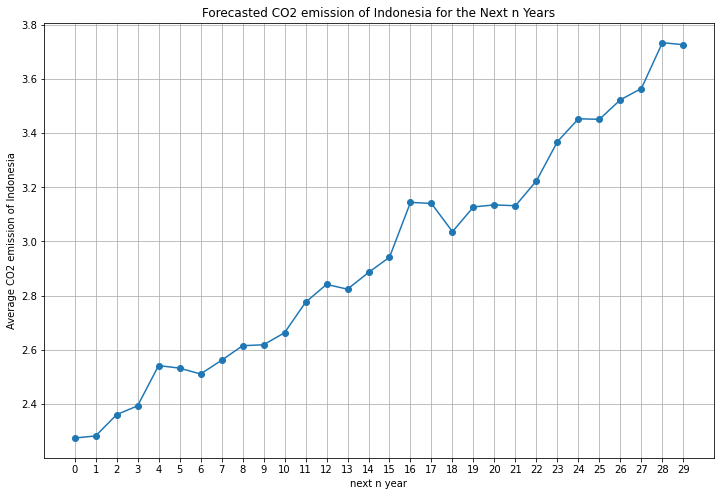

In [18]:
forecast = model_fit.forecast(steps=30)
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("next n year")
plt.ylabel("Average CO2 emission of Indonesia")
plt.title("Forecasted CO2 emission of Indonesia for the Next n Years")
plt.grid()
print(forecast_values)